In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import cv2
import timm

# ----------------------------------------
# 1. 设置和数据加载部分 (保持不变)
# ----------------------------------------
patches_folder = r"C:\Users\Alpaca_YT\pythonSet\lung_slices_dataset\lung_slice_xy"
# ### 修改点 1：为对照组实验创建新的输出文件夹 ###
output_model_dir = "Train_UNet256_control" 
os.makedirs(output_model_dir, exist_ok=True)
num_epochs = 15
batch_size = 8
learning_rate = 1e-4

all_fns = sorted([f for f in os.listdir(patches_folder) if f.lower().endswith((".jpg", ".png"))])
all_indices = list(range(len(all_fns)))
train_idxs, val_idxs = train_test_split(all_indices, test_size=0.25, random_state=42)

# (Dataset类的定义保持不变)
class RotLowHighDataset(Dataset):
    def __init__(self, patches_folder, indices, all_fns_list, transform=None):
        super().__init__()
        self.patches_folder, self.transform = patches_folder, transform or transforms.ToTensor()
        self.fns = [all_fns_list[i] for i in indices]
    def __len__(self): return len(self.fns) * 2
    def __getitem__(self, idx):
        img_idx, rot_flag = idx // 2, idx % 2
        fn = self.fns[img_idx]
        img_path = os.path.join(self.patches_folder, fn)
        arr = np.array(Image.open(img_path).convert("L"))
        if rot_flag == 1: arr = np.rot90(arr, k=1)
        down_arr = cv2.resize(arr, (256, 32), interpolation=cv2.INTER_AREA)
        up_img = cv2.resize(down_arr, (256, 256), interpolation=cv2.INTER_LINEAR)
        return self.transform(Image.fromarray(up_img)), self.transform(Image.fromarray(arr))

class PlainLowHighDataset(Dataset):
    def __init__(self, patches_folder, indices, all_fns_list, transform=None):
        super().__init__()
        self.patches_folder, self.transform = patches_folder, transform or transforms.ToTensor()
        self.fns = [all_fns_list[i] for i in indices]
    def __len__(self): return len(self.fns)
    def __getitem__(self, idx):
        fn = self.fns[idx]
        img_path = os.path.join(self.patches_folder, fn)
        arr = np.array(Image.open(img_path).convert("L"))
        down_arr = cv2.resize(arr, (256, 32), interpolation=cv2.INTER_AREA)
        up_img = cv2.resize(down_arr, (256, 256), interpolation=cv2.INTER_LINEAR)
        return self.transform(Image.fromarray(up_img)), self.transform(Image.fromarray(arr))

# ----------------------------------------
# 2. 定义传统的四层 UNet 模型
# ----------------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

# ### 修改点 2：将模型定义替换为 UNet256 ###
class UNet256(nn.Module):
    def __init__(self, in_ch=1, out_ch=1):
        super().__init__()
        # 编码器 (4次下采样)
        self.enc1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # 瓶颈层
        self.bottleneck = DoubleConv(512, 1024)
        
        # 解码器 (4次上采样)
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec4 = DoubleConv(1024 + 512, 512)
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = DoubleConv(512 + 256, 256)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = DoubleConv(256 + 128, 128)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = DoubleConv(128 + 64, 64)
        
        # 输出层
        self.outc = nn.Conv2d(64, out_ch, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        
        b = self.bottleneck(self.pool4(e4))
        
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        
        return self.outc(d1)

# ----------------------------------------
# 3. 准备训练 (修改模型实例化)
# ----------------------------------------
transform = transforms.ToTensor()
train_dataset = RotLowHighDataset(patches_folder, train_idxs, all_fns, transform)
val_dataset = PlainLowHighDataset(patches_folder, val_idxs, all_fns, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ### 修改点 3：实例化 UNet256 模型 ###
model = UNet256(in_ch=1, out_ch=1).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# 定义高频损失 (保持不变)
laplacian_kernel = torch.tensor(
    [[0.0, -1.0, 0.0], [-1.0, 4.0, -1.0], [0.0, -1.0, 0.0]],
    device=device, dtype=torch.float32
).view(1, 1, 3, 3)
lambda_hf = 0.5
def high_freq_loss(pred, target):
    pred_lap = F.conv2d(pred, laplacian_kernel, padding=1)
    tgt_lap  = F.conv2d(target, laplacian_kernel, padding=1)
    return F.mse_loss(pred_lap, tgt_lap)

# ----------------------------------------
# 4. 训练循环 (修改打印和保存信息)
# ----------------------------------------
print(f"开始在 {device} 上训练传统的 UNet256 模型 (作为对照组)...")
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0
    for inp, tgt in train_loader:
        inp, tgt = inp.to(device), tgt.to(device)
        optimizer.zero_grad()
        out = model(inp)
        
        mse_train = criterion(out, tgt)
        hf_train = high_freq_loss(out, tgt)
        loss = mse_train + lambda_hf * hf_train
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inp.size(0)
    avg_train_loss = train_loss / len(train_dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inp_v, tgt_v in val_loader:
            inp_v, tgt_v = inp_v.to(device), tgt_v.to(device)
            out_v = model(inp_v)
            
            mse_val = criterion(out_v, tgt_v)
            hf_val = high_freq_loss(out_v, tgt_v)
            loss_v = mse_val + lambda_hf * hf_val

            val_loss += loss_v.item() * inp_v.size(0)
    avg_val_loss = val_loss / len(val_dataset)

    print(f"Epoch {epoch:02d}/{num_epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
    
    # ### 修改点 4：使用新的文件名保存权重 ###
    ckpt_path = os.path.join(output_model_dir, f"UNet256_control_hf_epoch{epoch:02d}.pth")
    torch.save(model.state_dict(), ckpt_path)

print(f"\n训练完毕，所有模型已保存在 '{output_model_dir}/'")

开始在 cuda 上训练传统的 UNet256 模型 (作为对照组)...
Epoch 01/15 | Train Loss: 0.024262 | Val Loss: 0.015481


KeyboardInterrupt: 

开始在 cuda 上评估 'Train_UNet256_control' 的所有模型...


评估进度:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\Alpaca_YT\AppData\Local\Temp\ipykernel_29856\3253147108.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load


--- 评估结果汇总 ---
Epoch     Val PSNR       Val SSIM       Test PSNR      Test SSIM      
------------------------------------------------------------
1         23.1591        0.5358         22.9900        0.5148         
2         23.7088        0.5529         23.3925        0.5307         
3         23.7839        0.5622         23.4710        0.5381         
4         23.9046        0.5700         23.5053        0.5447         
5         24.1039        0.5773         23.6707        0.5488         
6         23.8757        0.5750         23.5143        0.5497         
7         24.1256        0.5854         23.6819        0.5564         
8         24.2177        0.5887         23.7447        0.5594         
9         24.1415        0.5869         23.7395        0.5600         
10        23.9470        0.5863         23.6269        0.5589         
11        24.3265        0.5949         23.8298        0.5647         
12        24.1468        0.5960         23.6912        0.5659         


C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packa

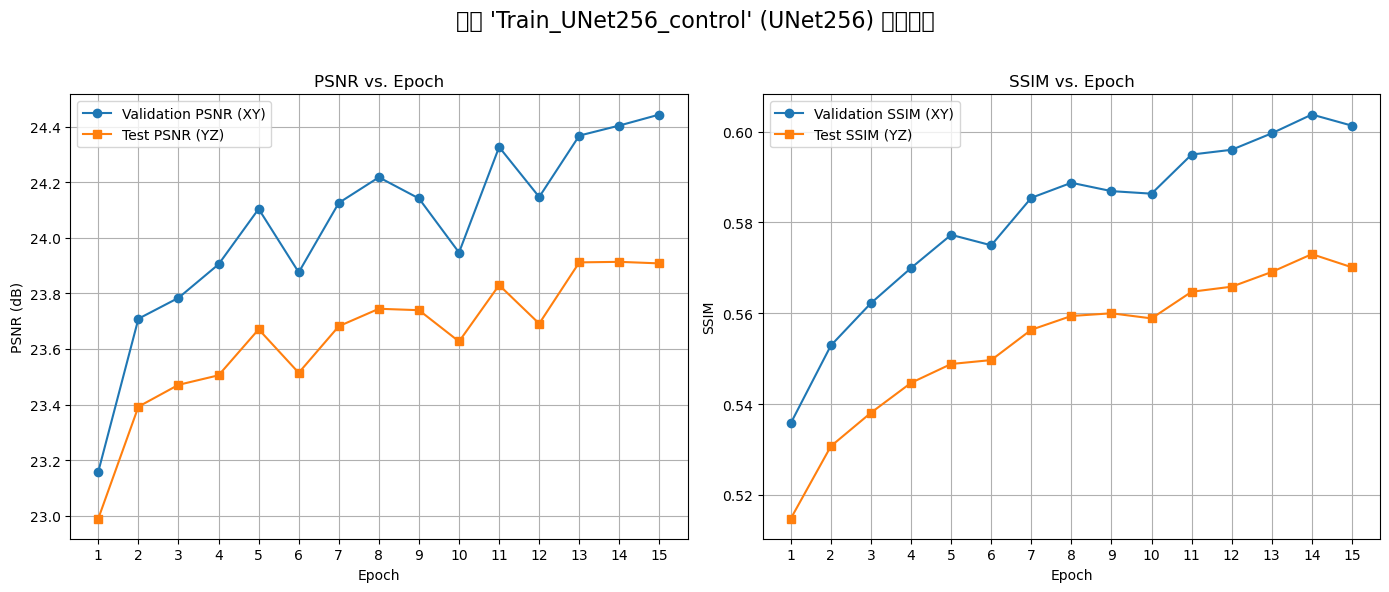

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# ----------------------------------------
# 1. 定义与训练时完全一致的模型和 Dataset 类
# ----------------------------------------

# ### 修改点 1：将模型定义替换为 UNet256 ###
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNet256(nn.Module):
    def __init__(self, in_ch=1, out_ch=1):
        super().__init__()
        # 编码器 (4次下采样)
        self.enc1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # 瓶颈层
        self.bottleneck = DoubleConv(512, 1024)
        
        # 解码器 (4次上采样)
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec4 = DoubleConv(1024 + 512, 512)
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = DoubleConv(512 + 256, 256)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = DoubleConv(256 + 128, 128)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = DoubleConv(128 + 64, 64)
        
        # 输出层
        self.outc = nn.Conv2d(64, out_ch, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        
        b = self.bottleneck(self.pool4(e4))
        
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        
        return self.outc(d1)

class PlainLowHighDataset(Dataset):
    def __init__(self, patches_folder, indices, all_fns_list, transform=None):
        super().__init__()
        self.patches_folder, self.transform = patches_folder, transform or transforms.ToTensor()
        self.fns = [all_fns_list[i] for i in indices]
    def __len__(self): return len(self.fns)
    def __getitem__(self, idx):
        fn = self.fns[idx]
        img_path = os.path.join(self.patches_folder, fn)
        arr = np.array(Image.open(img_path).convert("L"))
        down_arr = cv2.resize(arr, (256, 32), interpolation=cv2.INTER_AREA)
        up_img = cv2.resize(down_arr, (256, 256), interpolation=cv2.INTER_LINEAR)
        return self.transform(Image.fromarray(up_img)), self.transform(Image.fromarray(arr))

# ----------------------------------------
# 2. 设置路径和参数
# ----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.ToTensor()
# ### 修改点 2：使用 UNet256 的权重文件夹 ###
checkpoint_dir = "Train_UNet256_control"
num_epochs = 15

# 准备 Dataloaders (保持不变)
val_patches_folder = r"C:\Users\Alpaca_YT\pythonSet\lung_slices_dataset\lung_slice_xy"
all_val_fns = sorted([f for f in os.listdir(val_patches_folder) if f.lower().endswith((".jpg", ".png"))])
all_val_indices = list(range(len(all_val_fns)))
_, val_idxs = train_test_split(all_val_indices, test_size=0.25, random_state=42)
val_dataset = PlainLowHighDataset(val_patches_folder, val_idxs, all_val_fns, transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

test_patches_folder = r"C:\Users\Alpaca_YT\pythonSet\lung_slices_dataset\lung_slice_yz"
all_test_fns = sorted([f for f in os.listdir(test_patches_folder) if f.lower().endswith((".jpg", ".png"))])
all_test_indices = list(range(len(all_test_fns)))
test_dataset = PlainLowHighDataset(test_patches_folder, all_test_indices, all_test_fns, transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ----------------------------------------
# 3. 定义评估函数 (保持不变)
# ----------------------------------------
def evaluate_model(model, loader):
    total_psnr = total_ssim = n = 0
    model.eval()
    with torch.no_grad():
        for inp_t, tgt_t in loader:
            inp_t, tgt_t = inp_t.to(device), tgt_t.to(device)
            out_t = model(inp_t)
            pred_np = out_t.clamp(0, 1).cpu().squeeze().numpy()
            target_np = tgt_t.cpu().squeeze().numpy()
            total_psnr += psnr_metric(target_np, pred_np, data_range=1.0)
            total_ssim += ssim_metric(target_np, pred_np, data_range=1.0, channel_axis=None)
            n += 1
    return total_psnr / n, total_ssim / n

# ----------------------------------------
# 4. 循环评估所有Epoch并记录结果
# ----------------------------------------
epochs = list(range(1, num_epochs + 1))
val_psnrs, val_ssims = [], []
test_psnrs, test_ssims = [], []

print(f"开始在 {device} 上评估 '{checkpoint_dir}' 的所有模型...")

for epoch in tqdm(epochs, desc="评估进度"):
    # ### 修改点 3：构建 UNet256 的权重文件路径 ###
    ckpt_path = os.path.join(checkpoint_dir, f"UNet256_control_hf_epoch{epoch:02d}.pth")
    
    # ### 修改点 4：实例化 UNet256 模型并加载权重 ###
    model = UNet256(in_ch=1, out_ch=1).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    
    # 在验证集和测试集上评估
    vp, vs = evaluate_model(model, val_loader)
    tp, ts = evaluate_model(model, test_loader)
    
    # 记录结果
    val_psnrs.append(vp)
    val_ssims.append(vs)
    test_psnrs.append(tp)
    test_ssims.append(ts)

# ----------------------------------------
# 5. 打印表格形式的结果
# ----------------------------------------
print("\n--- 评估结果汇总 ---")
print("="*60)
print(f"{'Epoch':<10}{'Val PSNR':<15}{'Val SSIM':<15}{'Test PSNR':<15}{'Test SSIM':<15}")
print("-"*60)
for i in range(num_epochs):
    print(f"{i+1:<10}{val_psnrs[i]:<15.4f}{val_ssims[i]:<15.4f}{test_psnrs[i]:<15.4f}{test_ssims[i]:<15.4f}")
print("="*60)

# ----------------------------------------
# 6. 绘制结果图表
# ----------------------------------------
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_psnrs, 'o-', label='Validation PSNR (XY)')
plt.plot(epochs, test_psnrs, 's-', label='Test PSNR (YZ)')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs. Epoch')
plt.legend()
plt.grid(True)
plt.xticks(epochs)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_ssims, 'o-', label='Validation SSIM (XY)')
plt.plot(epochs, test_ssims, 's-', label='Test SSIM (YZ)')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('SSIM vs. Epoch')
plt.legend()
plt.grid(True)
plt.xticks(epochs)

# ### 修改点 5：更新图表标题 ###
plt.suptitle(f"模型 '{checkpoint_dir}' (UNet256) 性能评估", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import cv2
import timm
from torchvision import transforms

# ----------------------------------------
# 1. 定义与训练时完全一致的模型架构
# ----------------------------------------
# 确保这些定义与您训练模型时的代码完全相同
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UpBlockPixelShuffle(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch * 4, 3, 1, 1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x): return self.relu(self.pixel_shuffle(self.conv(x)))

class SwinUnet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, pretrained=True):
        super().__init__()
        self.in_ch = in_ch
        self.encoder = timm.create_model(
            'swin_tiny_patch4_window7_224', pretrained=pretrained, features_only=True,
            in_chans=3, img_size=256
        )
        encoder_channels = self.encoder.feature_info.channels()
        self.up4, self.dec4 = UpBlockPixelShuffle(encoder_channels[3], 512), DoubleConv(encoder_channels[2] + 512, 512)
        self.up3, self.dec3 = UpBlockPixelShuffle(512, 256), DoubleConv(encoder_channels[1] + 256, 256)
        self.up2, self.dec2 = UpBlockPixelShuffle(256, 128), DoubleConv(encoder_channels[0] + 128, 128)
        self.up1, self.dec1 = UpBlockPixelShuffle(128, 64), DoubleConv(64 + in_ch, 64)
        self.outc = nn.Conv2d(64, out_ch, kernel_size=1)
    def forward(self, x):
        x_orig = x
        if self.in_ch == 1: x = x.repeat(1, 3, 1, 1)
        features = self.encoder(x)
        e1, e2, e3, e4 = features[0].permute(0, 3, 1, 2), features[1].permute(0, 3, 1, 2), features[2].permute(0, 3, 1, 2), features[3].permute(0, 3, 1, 2)
        u4 = self.up4(e4)
        d4 = self.dec4(torch.cat([u4, e3], dim=1))
        u3 = self.up3(d4)
        d3 = self.dec3(torch.cat([u3, e2], dim=1))
        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, e1], dim=1))
        u1 = self.up1(d2)
        final_up = F.interpolate(u1, scale_factor=2, mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([final_up, x_orig], dim=1))
        return self.outc(d1)

# ----------------------------------------
# 2. 设置路径和参数
# ----------------------------------------
# 假设 block32_yz_003.jpg 在 "test_patches_YZ" 文件夹中
IMAGE_PATH = r"C:\Users\Alpaca_YT\pythonSet\lung_slices_dataset\lung_slice_yz\block32_yz_003.jpg"
CHECKPOINT_DIR = "Train_SwinUnet_v2_lung"
EPOCH_TO_LOAD = 15
OUTPUT_DIR = "UNET_test"

os.makedirs(OUTPUT_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.ToTensor()

# ----------------------------------------
# 3. 加载模型权重
# ----------------------------------------
model = SwinUnet(in_ch=1, out_ch=1, pretrained=False).to(device) # pretrained=False,因为我们要加载自己的权重
checkpoint_filename = f"SwinUnet_v2_hf_epoch{EPOCH_TO_LOAD:02d}.pth"
checkpoint_path = os.path.join(CHECKPOINT_DIR, checkpoint_filename)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print(f"成功加载模型权重: {checkpoint_path}")

# ----------------------------------------
# 4. 加载和预处理图像
# ----------------------------------------
# 加载原始高分辨率图像 (Ground Truth)
gt_image_pil = Image.open(IMAGE_PATH).convert("L")
gt_image_np = np.array(gt_image_pil)
gt_tensor = transform(gt_image_pil).unsqueeze(0).to(device)

print(f"已加载图像: {IMAGE_PATH}")

# 创建模型的低分辨率输入
# 1. 归一化到 [0, 1]
gt_image_float = gt_image_np.astype(np.float32) / 255.0
# 2. 垂直下采样8倍
lr_image_np = cv2.resize(gt_image_float, (256, 32), interpolation=cv2.INTER_AREA)
# 3. 线性插值回原始尺寸
input_image_np = cv2.resize(lr_image_np, (256, 256), interpolation=cv2.INTER_LINEAR)
# 4. 转换为Tensor
input_tensor = torch.from_numpy(input_image_np).unsqueeze(0).unsqueeze(0).to(device)

print("已生成模型的低分辨率输入。")

# ----------------------------------------
# 5. 执行模型推理
# ----------------------------------------
with torch.no_grad():
    output_tensor = model(input_tensor)
print("模型推理完成。")

# ----------------------------------------
# 6. 保存结果图像
# ----------------------------------------
def tensor_to_image(tensor):
    """将 [0,1] 范围的Tensor转换为可保存的PIL Image对象"""
    arr = tensor.clamp(0, 1).cpu().squeeze().numpy()
    return Image.fromarray((arr * 255).round().astype(np.uint8))

# 获取不带后缀的文件名
base_name = os.path.splitext(os.path.basename(IMAGE_PATH))[0]

# 保存三张图片
path_input = os.path.join(OUTPUT_DIR, f"{base_name}_01_input.png")
path_output = os.path.join(OUTPUT_DIR, f"{base_name}_02_reconstructed.png")
path_gt = os.path.join(OUTPUT_DIR, f"{base_name}_03_ground_truth.png")

tensor_to_image(input_tensor).save(path_input)
tensor_to_image(output_tensor).save(path_output)
tensor_to_image(gt_tensor).save(path_gt)

print(f"\n结果已保存至 '{OUTPUT_DIR}/' 文件夹:")
print(f"  - 输入图像: {path_input}")
print(f"  - 重建图像: {path_output}")
print(f"  - 原始图像: {path_gt}")

C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Alpaca_YT\AppData\Local\Temp\ipykernel_31276\2781379042.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_

成功加载模型权重: Train_SwinUnet_v2_lung\SwinUnet_v2_hf_epoch15.pth
已加载图像: C:\Users\Alpaca_YT\pythonSet\lung_slices_dataset\lung_slice_yz\block32_yz_003.jpg
已生成模型的低分辨率输入。
模型推理完成。

结果已保存至 'UNET_test/' 文件夹:
  - 输入图像: UNET_test\block32_yz_003_01_input.png
  - 重建图像: UNET_test\block32_yz_003_02_reconstructed.png
  - 原始图像: UNET_test\block32_yz_003_03_ground_truth.png
